# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [60]:
import numpy as np
import torch

D = np.loadtxt('data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [61]:
import torch

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

X = torch.hstack((torch.ones(X.shape[0], 1), X))

In [63]:
def mse(y_true, y_pred):
    return (y_true - y_pred).pow(2).mean()


class LinearRegression:
    def __init__(self, lr, momentum, C, epochs, batch_size, loss=mse):
        self.lr = lr
        self.momentum = momentum
        self.loss = loss
        self.C = C
        self.batch_size = batch_size
        
        self.theta = None
        self.losses = None
        self.prev_gradient = 0
        self.epochs = 100
        
    def fit(self, X, y):
        self.theta = torch.rand(X.shape[1], requires_grad=True)
        
        self.losses = []
        iters = X.shape[0] // self.batch_size
        
        for epoch in range(self.epochs):
            loss_acc = 0
            
            for i in range(iters):
                batch_left_part = i * self.batch_size
                batch_right_part = (i + 1) * self.batch_size
                
                y_pred = X[batch_left_part : batch_right_part] @ self.theta
                loss = self.loss(y[batch_left_part : batch_right_part], y_pred)

                loss += self.C * torch.norm(self.theta)
                loss.backward()

                with torch.no_grad():
                    loss_acc += loss.item()

                    gradient = self.lr * self.theta.grad
                    if self.momentum:
                        gradient += self.momentum * self.prev_gradient
                    self.theta -= gradient
                    self.prev_gradient = gradient
                    self.theta.grad.zero_()
                        
            self.losses.append(loss_acc / iters)

    def predict(self, X):
        return X @ self.theta
    

linear_regression = LinearRegression(lr=0.0005, C=0.1, momentum=0.9, epochs=100, batch_size=100)
linear_regression.fit(X, y)

y_pred = linear_regression.predict(X)
mse(y, y_pred)

tensor(94.9847, grad_fn=<MeanBackward0>)

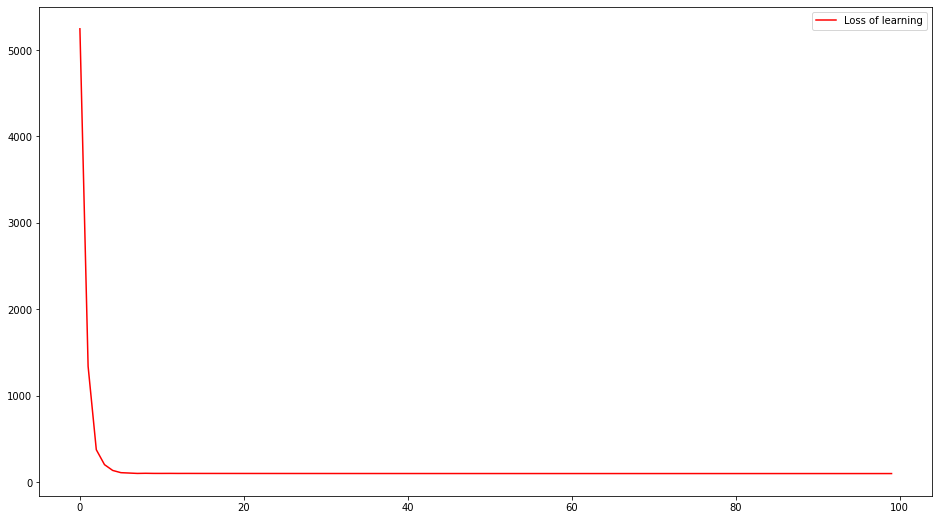

In [64]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(linear_regression.losses, color="r", label="Loss of learning")
plt.legend()
plt.show()

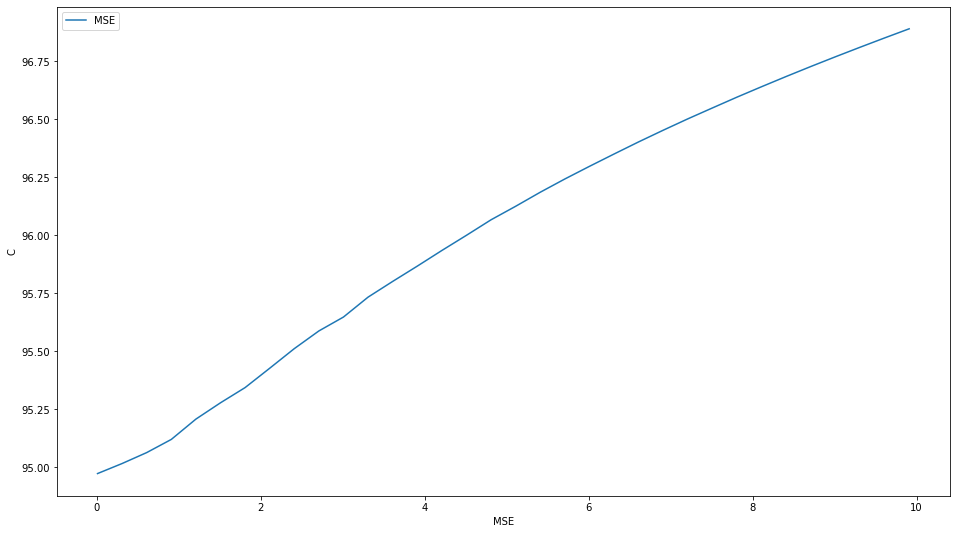

In [65]:
c_losses = []
train_losses = []
c_values = np.arange(0.01, 10, 0.3)

for C in c_values:
    linear_regression = LinearRegression(C=C, lr=0.0005, momentum=0.9, epochs=100, batch_size=100)

    linear_regression.fit(X, y)
    
    y_pred = linear_regression.predict(X)
    c_losses.append(mse(y, y_pred))
    
plt.figure(figsize=(16, 9))
plt.plot(c_values, c_losses, label="MSE")
plt.xlabel("MSE") 
plt.ylabel("C")
plt.legend()
plt.show()

In [66]:
class CrossValidation:
    def __init__(self, items_count, splits_count=5):
        self.items_count = items_count
        self.splits_count = splits_count
    
    def splits(self):
        indicies = np.arange(self.items_count)
        split_size = self.items_count // self.splits_count
        
        for i in range(self.splits_count):
            train_inds = indicies[0 : i * split_size]
            train_inds = np.hstack((train_inds, indicies[(i + 1) * split_size:]))
            validation_inds = indicies[i * split_size: (i + 1) * split_size]
            
            yield (train_inds, validation_inds)

In [67]:
def cv_score(Regressor, X, y, split_number=5, **params):
    regressor = Regressor(**params)
    
    validation_scores = np.zeros(split_number)
    train_scores = np.zeros(split_number)
    cv = CrossValidation(X.shape[0])

    for i, (train_inds, validation_inds) in enumerate(cv.splits()):
        regressor.fit(X[train_inds], y[train_inds])
        
        y_pred = regressor.predict(X[validation_inds])
        validation_scores[i] = mse(y[validation_inds], y_pred)
        
        y_pred = regressor.predict(X[train_inds])
        train_scores[i] = mse(y[train_inds], y_pred)
        
    return validation_scores, train_scores

cv_score(LinearRegression, X, y, C=20, lr=0.0005, momentum=0.9, epochs=100, batch_size=100)

(array([ 89.79787445,  90.16439819, 106.40010071, 108.22722626,
        105.78195953]),
 array([100.49811554, 100.99976349,  98.02877808,  95.27922821,
        100.72810364]))

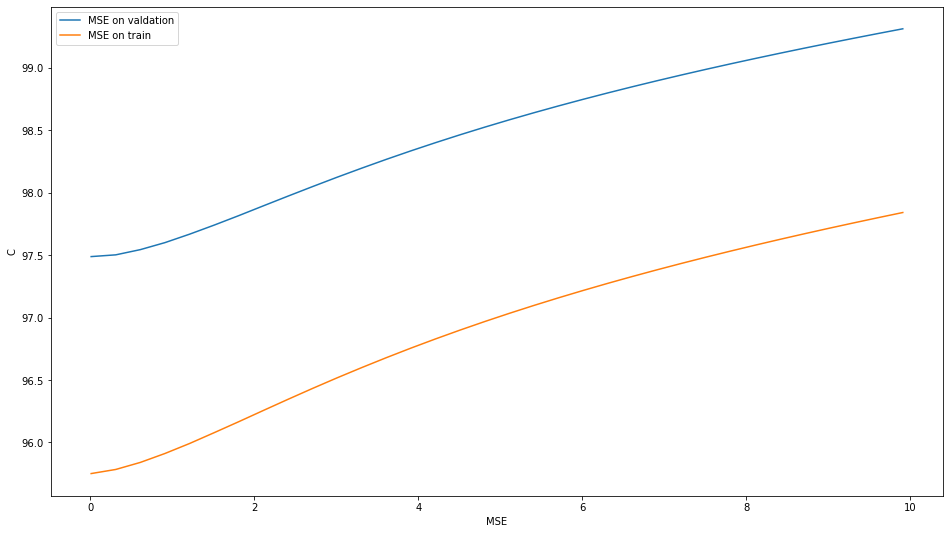

In [68]:
c_losses = []
train_losses = []
c_values = np.arange(0.01, 10, 0.3)

for C in c_values:
    scores, train_scores = cv_score(LinearRegression, X, y, C=C, momentum=0.9, lr=0.001, \
                                    epochs=100, batch_size=100)
    
    c_losses.append(scores.mean())
    train_losses.append(train_scores.mean())
    
plt.figure(figsize=(16, 9))

plt.plot(c_values, c_losses, label="MSE on valdation")
plt.plot(c_values, train_losses, label="MSE on train")

plt.xlabel("MSE") 
plt.ylabel("C")

plt.legend()
plt.show()

In [69]:
import random

class RandomSearch:
    def __init__(self, trials, params_bound, splits=5):
        self.trials = trials
        self.params_bound = params_bound
        self.splits = splits
        
    def search(self, Regressor, X, y):
        scores = []
        for i in range(self.trials):
            params = {
                key: random.uniform(v[0], v[1]) for key, v in self.params_bound.items()
            }
            scores.append(
            {
                "params": params,
                "scores": cv_score(Regressor, X, y, split_number=self.splits, **params,
                                   epochs=100, batch_size=100)[0].mean()
            })
        return scores

In [70]:
random_serach_cv = RandomSearch(10, {
    "lr": (0.001, 0.00001),
    "C": (0.1, 10),
    "momentum": (0.5, 0.95)
})

results = random_serach_cv.search(LinearRegression, X, y)

sorted(results, key=lambda x: x["scores"])[0]

{'params': {'lr': 0.0002056189548900804,
  'C': 4.7090279779254915,
  'momentum': 0.8773394791414213},
 'scores': 97.63431243896484}